In [1]:
from share import *
import config

import cv2
import einops
import numpy as np
import torch
import random
from PIL import Image

from pytorch_lightning import seed_everything
from modules.annotator.util import resize_image, HWC3
from modules.annotator.openpose import apply_openpose
from modules.cldm.model import create_model, load_state_dict
from modules.ldm.models.diffusion.ddim import DDIMSampler
from modules.annotator.midas import MidasDetector


/home/slvt/miniconda3/envs/sd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.
cuda
cuda


In [3]:
apply_midas = MidasDetector()

model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(
    './models/control_sd15_normal.pth', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

In [4]:
def process(input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, bg_threshold):
    with torch.no_grad():
        input_image = HWC3(input_image)
        _, detected_map = apply_midas(resize_image(input_image, detect_resolution), bg_th=bg_threshold)
        detected_map = HWC3(detected_map)
        img = resize_image(input_image, image_resolution)
        H, W, C = img.shape

        detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_LINEAR)

        control = torch.from_numpy(detected_map[:, :, ::-1].copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [detected_map] + results

In [8]:
input_image = np.asarray(Image.open('tmp.jpg'))
prompt = 'colorful and vibrant, whimsical pencil illustration, (diterlizziartai style), cthulu rising above the sleeping metropolis, detailed <lora:DiTerlizziArtAIccp:0.6>, highly detailed, high quality, intricate, 4k, uhd'
a_prompt = 'best quality, extremely detailed'
n_prompt = '(worst quality, low quality, thumbnail:1.4), signature, artist name, web address, cropped, jpeg artifacts, watermark, username, collage, grid, (photography, realistic, hyperrealistic:1.4)'
num_samples = 1
image_resolution = 512
detect_resolution = 512 
ddim_steps = 20
guess_mode = False
strength = 1.
scale = 9.
seed = 42
eta = 0.
bg_threshold = 0.4

In [9]:
items = process(input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, bg_threshold)

Seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 88), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]


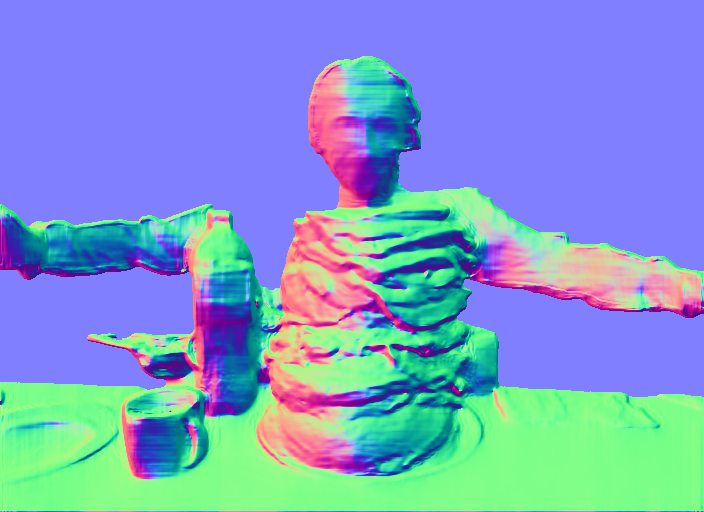

In [10]:
Image.fromarray(np.uint8(items[0])).convert('RGB')

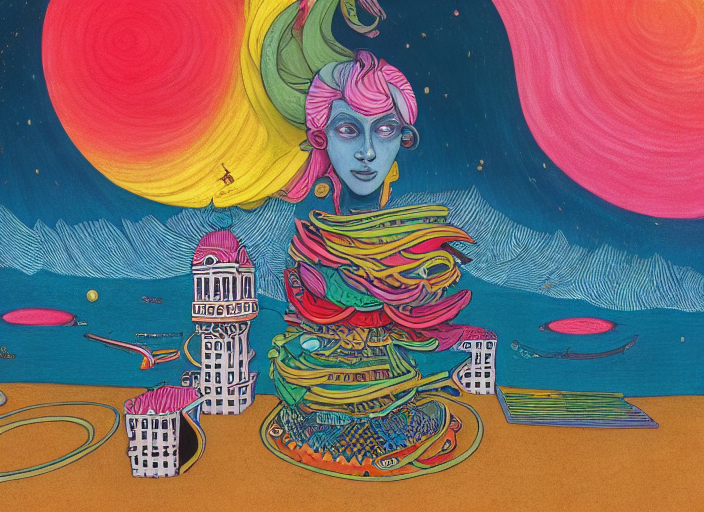

In [11]:
Image.fromarray(np.uint8(items[1])).convert('RGB')